## Indice Normalisé de Différence de l’Eau (NDWI)

### Description de l’indicateur

Le **NDWI (Normalized Difference Water Index)** est un indice spectral de
télédétection utilisé pour **détecter la présence de l’eau de surface** et
apprécier le **niveau d’humidité des milieux naturels**. Il est particulièrement
pertinent pour l’identification des plans d’eau, des zones inondées et des
surfaces à forte teneur en eau.

Le principe du NDWI repose sur le **contraste spectral entre la réflectance de
l’eau dans le vert et dans le proche infrarouge**. Les surfaces en eau
réfléchissent modérément le rayonnement dans le **vert**, mais absorbent
fortement le rayonnement dans le **proche infrarouge (NIR)**. À l’inverse, la
végétation et les sols secs présentent une réflectance plus élevée dans le NIR.

Ainsi, les zones riches en eau présentent des valeurs de NDWI plus élevées que
les surfaces sèches ou faiblement humides.

Les valeurs du NDWI sont comprises entre **−1 et +1** :

- **NDWI négatif** : surfaces sèches, sols nus, zones bâties ou végétation peu
  humide ;
- **NDWI proche de 0** : surfaces légèrement humides ou zones de transition ;
- **NDWI positif modéré (≈ 0.1 à 0.3)** : sols humides, zones inondables ou
  végétation avec une teneur en eau significative ;
- **NDWI élevé (> 0.3)** : plans d’eau, zones fortement inondées ou surfaces
  saturées en eau.

Le NDWI est couramment utilisé pour :
- la cartographie des plans d’eau et des zones humides ;
- le suivi des inondations et des variations saisonnières de l’eau ;
- l’analyse du stress hydrique et des conditions hydrologiques ;
- les études environnementales et climatiques.

---

### Méthodologie de calcul

Dans le cadre des données **Sentinel-2**, le NDWI est calculé à partir des bandes
spectrales suivantes :

- **B3 (Vert)** : bande centrée autour de **560 nm**, présentant une réflectance
  relativement élevée pour l’eau ;
- **B8 (Proche infrarouge – NIR)** : bande centrée autour de **842 nm**, fortement
  absorbée par l’eau.

Ces bandes sont utilisées à une **résolution spatiale de 10 m** (ou rééchantillonnées
à une résolution commune si nécessaire).

La formule du NDWI est définie comme suit :

$$
NDWI = \frac{Green - NIR}{Green + NIR}
$$

où :
- $Green$ représente la réflectance de la bande **B3** ;
- $NIR$ représente la réflectance de la bande **B8**.

La normalisation de l’indice permet :
- de limiter l’influence des variations d’illumination ;
- d’améliorer la comparabilité spatiale et temporelle ;
- d’obtenir un indicateur adimensionnel borné entre −1 et +1.

---


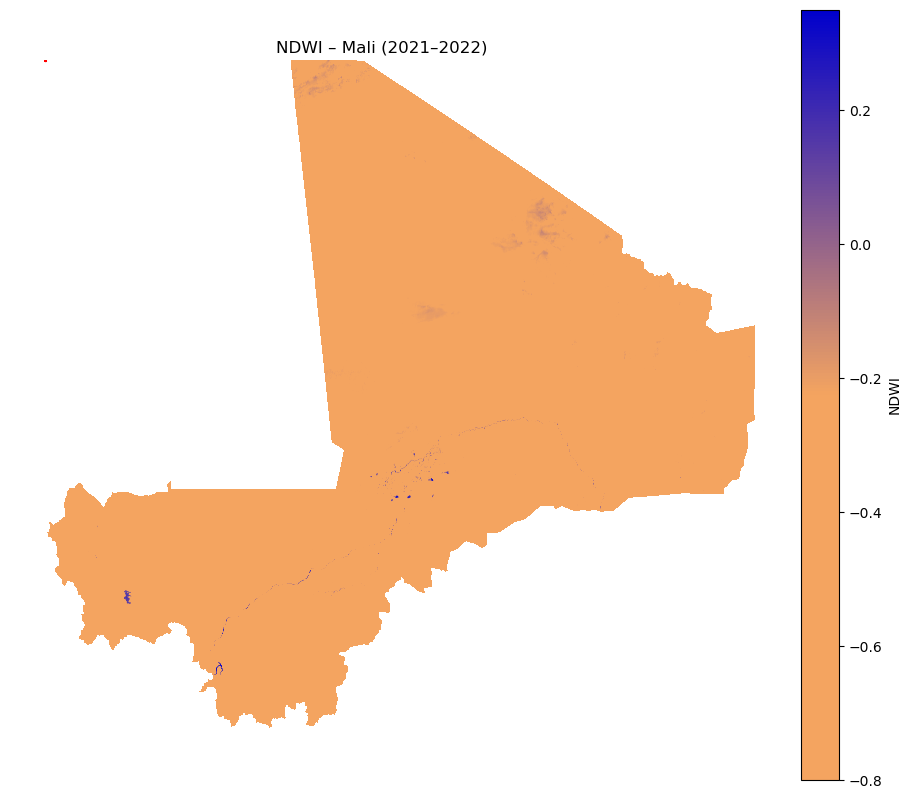

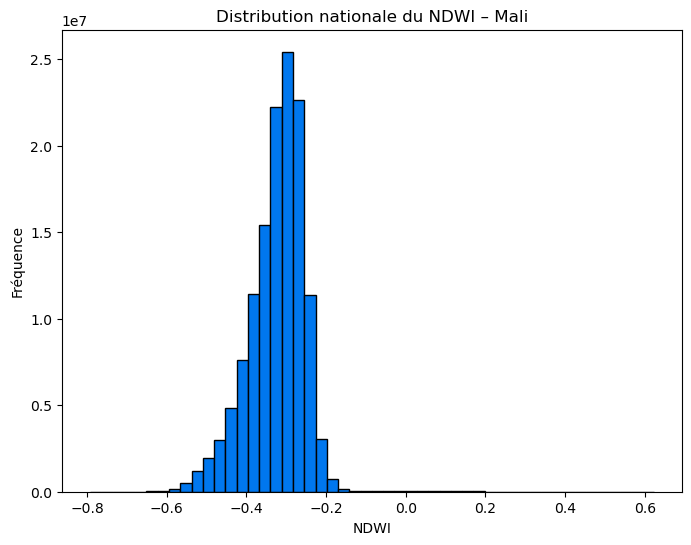

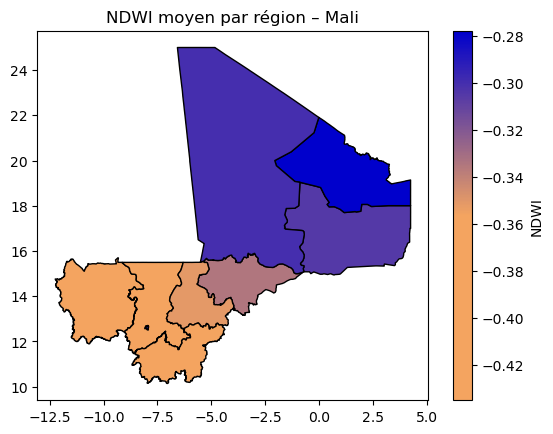

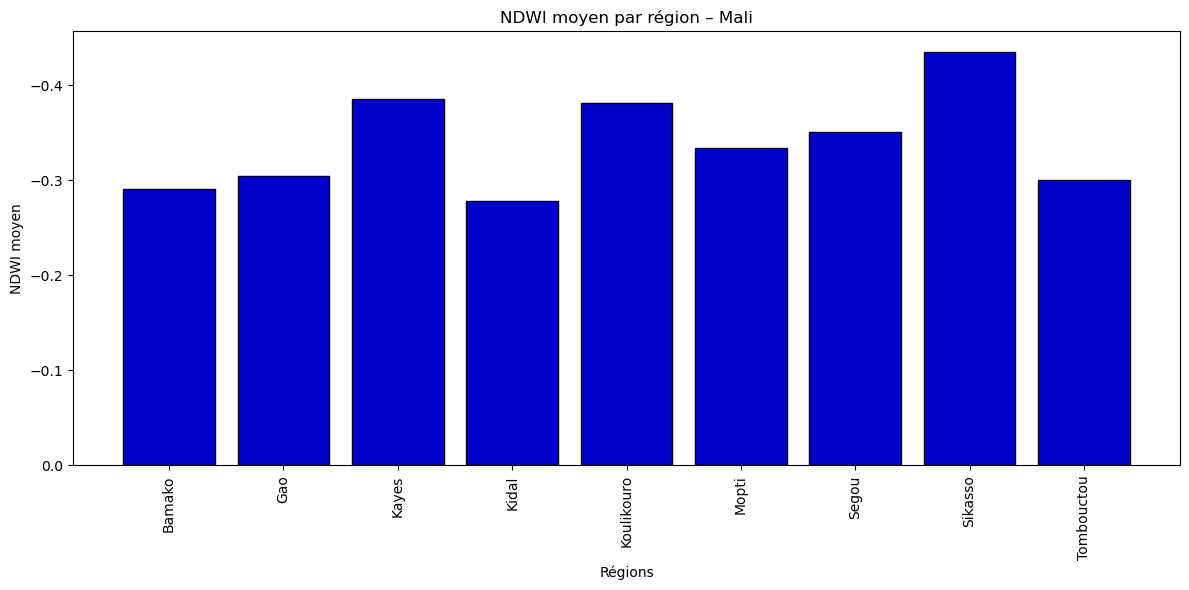

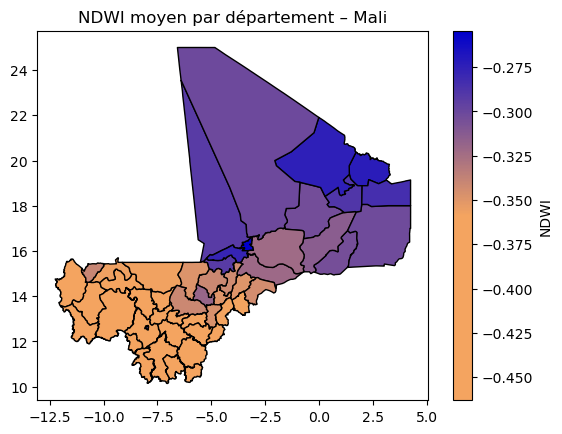

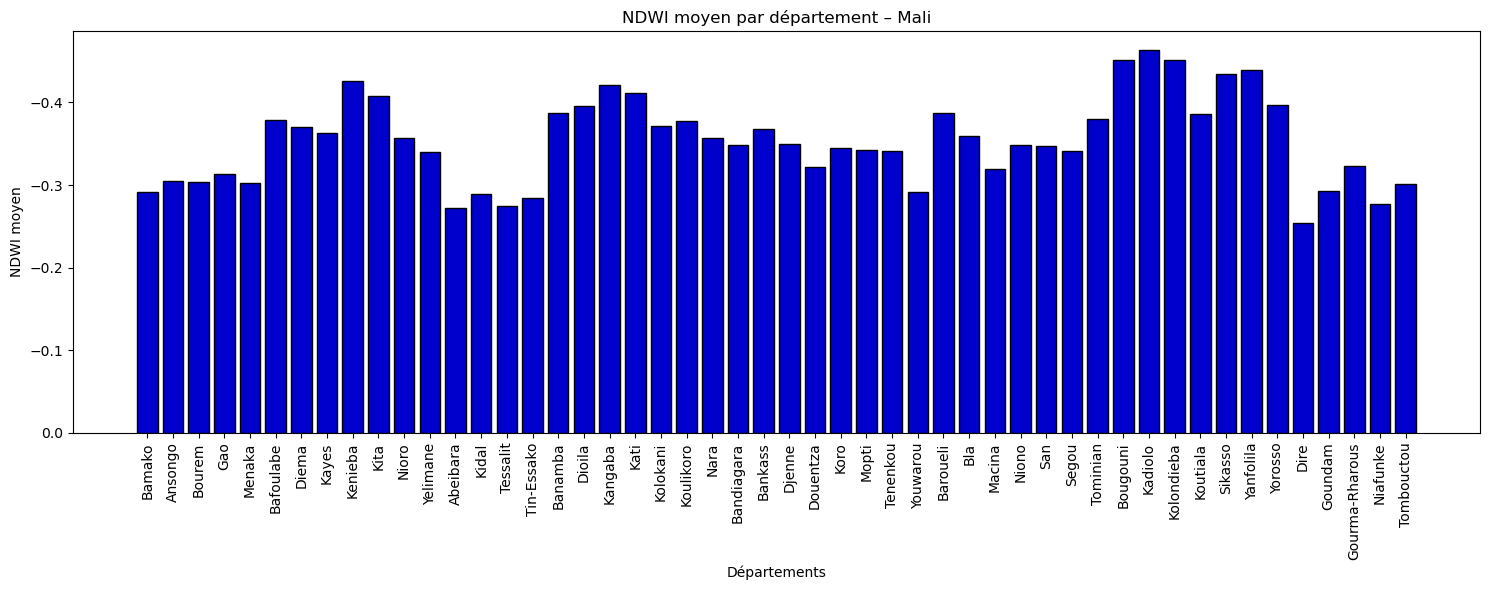

Table départementale NDWI enregistrée dans outputs/NDWI/


In [2]:
# ======================================================
# NDWI.ipynb – Calcul et analyse exploratoire du NDWI
# ======================================================

import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.mask import mask
from matplotlib.colors import LinearSegmentedColormap, Normalize

# 1️⃣ Chemins
BASE_DIR = os.getcwd()  # tp/scripts
DATA_DIR = os.path.join(BASE_DIR, "..", "data")
OUTPUT_DIR = os.path.join(BASE_DIR, "..", "outputs", "NDWI")
os.makedirs(OUTPUT_DIR, exist_ok=True)

path_b3 = os.path.join(DATA_DIR, "Mali_2022_B3_100m.tif")  # Green
path_b8 = os.path.join(DATA_DIR, "Mali_2022_B8_100m.tif")  # NIR

# 2️⃣ Lecture des rasters
with rasterio.open(path_b3) as src:
    green = src.read(1).astype("float32")
    profile = src.profile

with rasterio.open(path_b8) as src:
    nir = src.read(1).astype("float32")

# 3️⃣ Calcul NDWI
np.seterr(divide='ignore', invalid='ignore')
ndwi = (green - nir) / (green + nir)
ndwi = np.where((ndwi < -1) | (ndwi > 1), np.nan, ndwi)

# 4️⃣ Palette GEE NDWI
colors = ["#F4A460", "#F4A460", "#0000CC"] 
ndwi_cmap = LinearSegmentedColormap.from_list("ndwi_cmap", colors)
ndwi_norm = Normalize(vmin=-0.8, vmax=0.35)

# 5️⃣ Carte nationale NDWI avec limites pays
mali_shape = gpd.read_file(os.path.join(DATA_DIR, "mli_admin0.shp"))
mali_shape = mali_shape.to_crs(profile['crs'])

plt.figure(figsize=(12, 10))
plt.imshow(ndwi, cmap=ndwi_cmap, norm=ndwi_norm)
mali_shape.boundary.plot(edgecolor="red", linewidth=1.5, ax=plt.gca())
plt.colorbar(label="NDWI")
plt.title("NDWI – Mali (2021–2022)")
plt.axis("off")
plt.savefig(os.path.join(OUTPUT_DIR, "NDWI_nationale.png"), dpi=300)
plt.show()

# Histogramme national
plt.figure(figsize=(8, 6))
plt.hist(ndwi[~np.isnan(ndwi)], bins=50, color="#0077ee", edgecolor="black")
plt.title("Distribution nationale du NDWI – Mali")
plt.xlabel("NDWI")
plt.ylabel("Fréquence")
plt.savefig(os.path.join(OUTPUT_DIR, "NDWI_histogramme_nationale.png"), dpi=300)
plt.show()

# 6️⃣ Analyse régionale (Admin1)
gadm1 = gpd.read_file(os.path.join(DATA_DIR, "mli_admin1.shp"))
gadm1 = gadm1.to_crs(profile['crs'])
regional_ndwi = []

for idx, row in gadm1.iterrows():
    geom = [row['geometry']]
    with rasterio.open(path_b3) as src:
        green_clip, _ = mask(src, geom, crop=True)
    with rasterio.open(path_b8) as src:
        nir_clip, _ = mask(src, geom, crop=True)
    green_clip = green_clip[0].astype("float32")
    nir_clip = nir_clip[0].astype("float32")
    ndwi_clip = (green_clip - nir_clip) / (green_clip + nir_clip)
    ndwi_clip = np.where((ndwi_clip < -1) | (ndwi_clip > 1), np.nan, ndwi_clip)
    regional_ndwi.append(np.nanmean(ndwi_clip))

gadm1['NDWI'] = regional_ndwi

# Carte régionale
gadm1.plot(column='NDWI', cmap=ndwi_cmap, edgecolor='black', legend=True,
           legend_kwds={'label': "NDWI", 'orientation': "vertical"})
plt.title("NDWI moyen par région – Mali")
plt.savefig(os.path.join(OUTPUT_DIR, "NDWI_regionale.png"), dpi=300)
plt.show()

# Bar plot régional inversé
plt.figure(figsize=(12, 6))
plt.bar(gadm1['shapeName'], gadm1['NDWI'], color="#0000CC", edgecolor="black")
plt.xticks(rotation=90)
plt.title("NDWI moyen par région – Mali")
plt.xlabel("Régions")
plt.ylabel("NDWI moyen")
plt.gca().invert_yaxis()  # inversé pour esthétique
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "NDWI_bar_region.png"), dpi=300)
plt.show()

# 7️⃣ Analyse départementale (Admin2)
gadm2 = gpd.read_file(os.path.join(DATA_DIR, "mli_admin2.shp"))
gadm2 = gadm2.to_crs(profile['crs'])
dept_ndwi = []

for idx, row in gadm2.iterrows():
    geom = [row['geometry']]
    with rasterio.open(path_b3) as src:
        green_clip, _ = mask(src, geom, crop=True)
    with rasterio.open(path_b8) as src:
        nir_clip, _ = mask(src, geom, crop=True)
    green_clip = green_clip[0].astype("float32")
    nir_clip = nir_clip[0].astype("float32")
    ndwi_clip = (green_clip - nir_clip) / (green_clip + nir_clip)
    ndwi_clip = np.where((ndwi_clip < -1) | (ndwi_clip > 1), np.nan, ndwi_clip)
    dept_ndwi.append(np.nanmean(ndwi_clip))

gadm2['NDWI'] = dept_ndwi

# Carte départementale
gadm2.plot(column='NDWI', cmap=ndwi_cmap, edgecolor='black', legend=True,
           legend_kwds={'label': "NDWI", 'orientation': "vertical"})
plt.title("NDWI moyen par département – Mali")
plt.savefig(os.path.join(OUTPUT_DIR, "NDWI_departementale.png"), dpi=300)
plt.show()

# Bar plot départemental inversé
plt.figure(figsize=(15, 6))
plt.bar(gadm2['shapeName'], gadm2['NDWI'], color="#0000CC", edgecolor="black")
plt.xticks(rotation=90)
plt.title("NDWI moyen par département – Mali")
plt.xlabel("Départements")
plt.ylabel("NDWI moyen")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "NDWI_bar_departements.png"), dpi=300)
plt.show()

# Enregistrer la table départementale NDWI
ndwi_table = gadm2[['shapeName', 'NDWI']].copy()
ndwi_table.to_csv(os.path.join(OUTPUT_DIR, "NDWI_departements.csv"), index=False)
print("Table départementale NDWI enregistrée dans outputs/NDWI/")
